# Quantization of the qubit-readout resonator coupling
In this notebook we use QuCAT package to extract parameters of interests (kerr matrix, frequencies) from a lumped circuit model and the qubit-coupler capacitance matrix.

In [21]:
from qucat import Network,L,J,C,R
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import pi
from sympy import symbols
from skrf.media.cpw import CPW

In [22]:
# Load the capacitance matrix
# path_to_cmatrix = 'clockmon/clockmon_capacitance_sim_output_q3d_results.csv'
# path_to_cmatrix = 'doublepads/double_pads_sim_output_q3d_results.csv'
path_to_cmatrix = 'clockmon/libraries/clockmon_capacitance_sim_q3d_results.csv'
cmatrix = pd.read_csv(path_to_cmatrix)

C11 = cmatrix["C11"].iloc[0]
C12 = cmatrix["C12"].iloc[0]
C13 = cmatrix["C13"].iloc[0]
C21 = cmatrix["C21"].iloc[0]
C22 = cmatrix["C22"].iloc[0]
C23 = cmatrix["C23"].iloc[0]
C31 = cmatrix["C31"].iloc[0]
C32 = cmatrix["C32"].iloc[0]
C33 = cmatrix["C33"].iloc[0]

# KQCircuit's DoublePad has a different port convention and the cmatrix should be loaded differently:
# # 1 -> 3
# # 3 -> 2
# # 2 -> 1
# C11 = cmatrix["C33"].iloc[0]
# C12 = cmatrix["C13"].iloc[0]
# C13 = cmatrix["C23"].iloc[0]
# C21 = cmatrix["C13"].iloc[0]
# C22 = cmatrix["C11"].iloc[0]
# C23 = cmatrix["C12"].iloc[0]
# C31 = cmatrix["C23"].iloc[0]
# C32 = cmatrix["C12"].iloc[0]
# C33 = cmatrix["C22"].iloc[0]

In [23]:
# Compute C_Sigma and C_qr
# Formulas adapted from https://qudev.phys.ethz.ch/static/content/science/Documents/semester/Burkhard_Simon_SemesterThesis_130211.pdf
c33, c22, c11, c23, c13, c12 = symbols('c33, c22, c11, c23, c13, c12')
c_sigma = ((c33 + c13)*(c22 + c12))/(c33 + c22 + c13 + c12) + c23

# c_sigma = (c22*c33)/(c22 + c33) + c23 # This approximation neglects the coupler-islands terms

beta = (c33*c12 - c22*c13)/((c33+c13)*(c22 + c12) + (c33 + c22 + c13 + c12)*c23)
c_qr = beta*c_sigma

c_sigma = c_sigma.subs(c33, C33)
c_sigma = c_sigma.subs(c22, C22)
c_sigma = c_sigma.subs(c11, C11)
c_sigma = c_sigma.subs(c23, C23)
c_sigma = c_sigma.subs(c13, C13)
c_sigma = c_sigma.subs(c12, C12)

c_qr = c_qr.subs(c33, C33)
c_qr = c_qr.subs(c22, C22)
c_qr = c_qr.subs(c11, C11)
c_qr = c_qr.subs(c23, C23)
c_qr = c_qr.subs(c13, C13)
c_qr = c_qr.subs(c12, C12)

c_sigma = float(c_sigma)
c_qr = float(c_qr)
print(f"C_Sigma = {c_sigma} F")
print(f"C_qr = {c_qr} F")

C_Sigma = 9.006865227433394e-14 F
C_qr = 4.927340211579885e-15 F


In [24]:
# Define the Qubit-resonator network
Z0 = CPW( w = 10e-6, s = 6e-6, ep_r = 11.9).z0[0].real
readout_res_frequency = 6.5e9
l_r = Z0*pi/(4*pi*readout_res_frequency)
c_r = 1/((2*pi*readout_res_frequency)**2*l_r)
cir = Network([
        C(0,1,c_sigma -c_qr ), # transmon
        J(0,1,'Lj'),
        C(0,2,c_r), # resonator
        L(0,2,l_r),
        C(1,2,c_qr), # coupling capacitor
    ])

In [25]:
# Compute hamiltonian (for h=1, so all energies are expressed in frequency units, not angular)
H = cir.hamiltonian(
    modes = [0, 1],# Include modes 0 and 1
    taylor = 4,# Taylor the Josephson potential to the power 4
    excitations = [10, 10],# Consider 10 excitations in mode 0, 10 for mode 1
    Lj = 13.539e-9)# set any component values that were not fixed when building the circuit

# QuTiP method which return the eigenergies of the system
ee = H.eigenenergies()

In [26]:
1 / np.sqrt(c_sigma * 13.539e-9) / 2/ np.pi

4557639867.033993

In [27]:
first_transition = ee[1]-ee[0] # in units of Hertz
# print this frequency in GHz units
print("%.3f GHz"%((first_transition)/1e9))

4.315 GHz


In [28]:
# We assume that: (|qubit state, resonator state>)
# ee[0] -> |00>
# ee[1] -> |10>
# ee[2] -> |01>
# ee[3] -> |20>
anharmonicity = ee[1] - ee[0] - (ee[3] - ee[1]) # in units of Hertz
# print this frequency in GHz units
print("%.3f GHz"%((anharmonicity)/1e9))

0.281 GHz


In [29]:
# note that "f" here is simply 1/sqrt(LC)/2pi
f,k,A,chi = cir.f_k_A_chi(pretty_print=True,Lj = 13.539e-9)


         mode |       freq.  |       diss.  |       anha.  |
            0 |     4.56 GHz |          0Hz |      214 MHz |
            1 |     6.45 GHz |          0Hz |     1.23 kHz |

Kerr coefficients (diagonal = Kerr, off-diagonal = cross-Kerr)
         mode |         0    |         1    |
            0 |      214 MHz |              |
            1 |     1.03 MHz |     1.23 kHz |



c:\Users\labranca\Desktop\work\.venv\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\labranca\Desktop\work\.venv\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


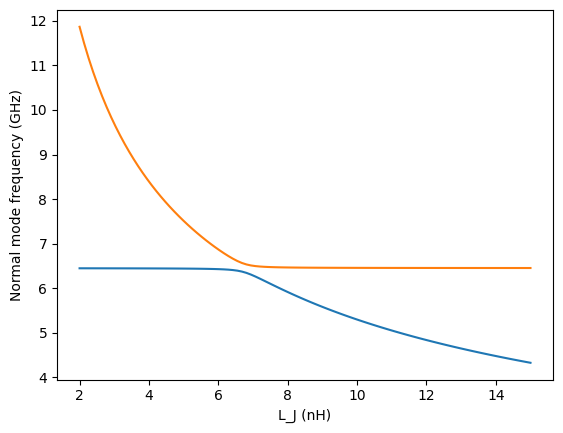

In [30]:
# array of values for the josephson inductance
Lj_list = np.linspace(2e-9,15e-9,101)

# Eigen-frequencies of the system:
freqs = cir.eigenfrequencies(Lj=Lj_list)

# plot first mode
plt.plot(Lj_list*1e9,freqs[0]/1e9)

# plot second mode
plt.plot(Lj_list*1e9,freqs[1]/1e9)

# Add labels
plt.xlabel('L_J (nH)')
plt.ylabel('Normal mode frequency (GHz)')

# show the figure
plt.show()